In [1]:
import sys
sys.path.insert(1, '..')
sys.path.insert(2, '../modules/')
import drms
from ruffus import *
import os
import re
import pickle
import dataconfig
import warnings

warnings.filterwarnings("ignore")

from modules import convert_datetime
from modules import query_the_data
from modules import sxi_module
from modules import helio_reg_exp_module
from time import sleep
from random import randint
from astropy.time import Time
import sqlalchemy as sa
import pandas as pd

import random

import json

from datetime import datetime, timedelta

loaded libraries sxi module: 0:00:01.124554
loaded libraries sxi module: 0:00:00.000021


In [2]:
client = drms.Client()

In [3]:
def make_drms_ar_availability_filename_sharp(jsoc_query_str):

    sub2 = re.sub('hmi.sharp_720s\[', '', jsoc_query_str)

    sub3 = re.sub(' ','', sub2)

    sub4 = re.sub(']', '', sub3)

    sub5 = re.sub('\[', '', sub4)

    return(sub5)

In [4]:
def make_drms_ar_availability_filename_Mharp(jsoc_query_str):
    
    sub2 = re.sub('hmi.Mharp_720s\[', '', jsoc_query_str)

    sub3 = re.sub(' ','', sub2)

    sub4 = re.sub(']', '', sub3)

    sub5 = re.sub('\[', '', sub4)

    return(sub5)

In [5]:
def make_hmi_jsoc_availability_query_string_sharp(time_ex_1, time_ex_2):

    time_str_1 = f'{time_ex_1:%Y.%m.%d}'

    time_str_2 = f'{time_ex_2:%Y.%m.%d}'

    query_str = f'hmi.sharp_720s[][{time_str_1} - {time_str_2}]'

    return(query_str)

In [6]:
def make_hmi_jsoc_availability_query_string_Mharp(time_ex_1, time_ex_2):

    time_str_1 = f'{time_ex_1:%Y.%m.%d}'

    time_str_2 = f'{time_ex_2:%Y.%m.%d}'

    query_str = f'hmi.Mharp_720s[][{time_str_1} - {time_str_2}]'

    return(query_str)

In [7]:
def convert_TAI_to_UTC(TAI_STR):
    
    sub = re.sub('\.', '-',TAI_STR)

    sub2 = re.sub('_', 'T', sub)

    sub3 = re.sub('TTAI', '', sub2)

    t = Time(sub3, scale='tai')

    utc = t.utc

    pandas_timestamp = convert_datetime.astropytime_to_pythondatetime(utc)


    return(pandas_timestamp)

In [8]:
def test_same_dfs(harp_df, sharp_df):

    A = sharp_df[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].reset_index(drop = True)
    B = harp_df[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].dropna().reset_index(drop = True)


    diff = A[['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN', 'HARPNUM']] - B[['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN', 'HARPNUM']]

    non_zero_diff = diff[(diff != 0).any(axis=1)]

    return(len(non_zero_diff) == 0)

In [9]:
def if_test_ok_return_dfs(harp_df, sharp_df):

    A = sharp_df.reset_index(drop = True)
    B = harp_df.dropna().reset_index(drop = True)


    return(A,B)

In [133]:
def create_hmi_pix_bbox(row):

    IMCRPIX1, IMCRPIX2 = row['IMCRPIX1'], row['IMCRPIX2']
    XDIM_CCD, YDIM_CCD = row['CRSIZE1'], row['CRSIZE2']
    CRPIX1, CRPIX2 = row['CRPIX1'], row['CRPIX2']

    # print(IMCRPIX1, IMCRPIX2,XDIM_CCD, YDIM_CCD,CRPIX1, CRPIX2)

    # # lower left-hand corner
    x_min = (IMCRPIX1 + CRPIX1 - XDIM_CCD)
    y_min = (IMCRPIX2 + CRPIX2 - YDIM_CCD) 

    # upper right-hand corner
    x_max = (IMCRPIX1 + CRPIX1)
    y_max = (IMCRPIX2 + CRPIX2)


    hmi_pix_bbox = [[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min], [x_min, y_min]]

    return(hmi_pix_bbox)

In [11]:
def str_w_Z_at_end_to_pythondatetime(time_str):

    time_str_wo_Z = time_str[:-1]

    datetime_obj = datetime.strptime(time_str_wo_Z,'%Y-%m-%dT%H:%M:%S.%f' )

    return(pd.Timestamp(datetime_obj, tz = 'utc'))

In [12]:
def convert_columns_to_python_datetime(input_df):

    copy_df = input_df.copy()

    copy_df['T_OBS'] = [convert_TAI_to_UTC(tai_str) for tai_str in copy_df['T_OBS']]

    copy_df['T_FRST'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_FRST']]

    copy_df['T_FRST1'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_FRST1']]

    copy_df['T_LAST'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_LAST']]

    copy_df['T_LAST1'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_LAST1']]

    copy_df['T_REC'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_REC']]

    copy_df['DATE-OBS'] = [convert_datetime.str_w_Z_at_end_to_pythondatetime(this_z_str_datetime) for this_z_str_datetime in copy_df['DATE-OBS']]

    return(copy_df)

In [13]:
def convert_columns_to_UNIX_timestamp(input_df):

    copy_df = input_df.copy()

    copy_df['T_OBS'] = [convert_datetime.convert_datetime_to_timestamp(tai_str) for tai_str in copy_df['T_OBS']]

    copy_df['T_FRST'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_FRST']]

    copy_df['T_FRST1'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_FRST1']]

    copy_df['T_LAST'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_LAST']]

    copy_df['T_LAST1'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_LAST1']]

    copy_df['DATE-OBS'] = [convert_datetime.convert_datetime_to_timestamp(this_z_str_datetime) for this_z_str_datetime in copy_df['DATE-OBS']]

    return(copy_df)

In [14]:
def create_HGS_bbox(AR_DF_ROW):

    x_min, x_max, y_min, y_max = AR_DF_ROW.LON_MIN, AR_DF_ROW.LON_MAX, AR_DF_ROW.LAT_MIN, AR_DF_ROW.LAT_MAX

    list = [[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min], [x_min, y_min]]

    return(list)

In [15]:

# 2012.03.06_23:29:06 --- Bobras test SHARP from https://github.com/mbobra/SHARPs/blob/master/feature_extraction.ipynb

start_download_from = '2012-03-06T00:00:00'
end_download_at = '2012-03-07T00:00:00'

START_DATE_TIME = pd.Timestamp(start_download_from, tz = 'utc')

END_DATE_TIME = pd.Timestamp(end_download_at, tz = 'utc')

frequency = '1D'

datelist = pd.date_range(start = START_DATE_TIME , end = END_DATE_TIME, freq = frequency ).tolist()

this_query_list_Mharp = [make_hmi_jsoc_availability_query_string_Mharp(previous,current) for previous,current in zip(datelist[:], datelist[1:])]

this_query_list_sharp = [make_hmi_jsoc_availability_query_string_sharp(previous,current) for previous,current in zip(datelist[:], datelist[1:])]


joint_list = [[m_harp_query, sharp_query] for m_harp_query, sharp_query in zip(this_query_list_Mharp,this_query_list_sharp)]

In [16]:
joint_list

[['hmi.Mharp_720s[][2012.03.06 - 2012.03.07]',
  'hmi.sharp_720s[][2012.03.06 - 2012.03.07]']]

In [69]:
jsoc_query_Mharp = joint_list[0] [0]

jsoc_query_sharp = joint_list[0][1]

jsoc_query_Mharp,jsoc_query_sharp


('hmi.Mharp_720s[][2012.03.06 - 2012.03.07]',
 'hmi.sharp_720s[][2012.03.06 - 2012.03.07]')

In [70]:
series_info_sharp = client.info("hmi.sharp_720s")
series_info_Mharp = client.info("hmi.Mharp_720s")


In [71]:
print(f"Listing keywords for {series_info_sharp.name}:\n")
for keyword in sorted(series_info_sharp.keywords.index):
    keyword_info = series_info_sharp.keywords.loc[keyword]
    print(keyword)
    print(f"  type ....... {keyword_info.type} ")
    print(f"  recscope ... {keyword_info.recscope} ")
    print(f"  defval ..... {keyword_info.defval} ")
    print(f"  units ...... {keyword_info.units} ")
    print(f"  note ....... {keyword_info.note} ")

series_info_Mharp = client.info("hmi.Mharp_720s")


Listing keywords for hmi.sharp_720s:

ABSNJZH
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... (G^2)/m 
  note ....... Absolute value of the net current helicity 
ACTIVE
  type ....... int 
  recscope ... variable 
  defval ..... -2147483648 
  units ...... none 
  note ....... Mask value for active region pixels 
AMBBTHR0
  type ....... double 
  recscope ... variable 
  defval ..... nan 
  units ...... G 
  note ....... Transverse field strength threshold at disk center for using simulated annealing 
AMBBTHR1
  type ....... double 
  recscope ... variable 
  defval ..... nan 
  units ...... G 
  note ....... Transverse field strength threshold at limb for using simulated annealing 
AMBCODEV
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... Version of Disambig code 
AMBDOCU
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... Document for Disambig code 
A

In [72]:
print(f"Listing keywords for {series_info_Mharp.name}:\n")
for keyword in sorted(series_info_Mharp.keywords.index):
    keyword_info = series_info_Mharp.keywords.loc[keyword]
    print(keyword)
    print(f"  type ....... {keyword_info.type} ")
    print(f"  recscope ... {keyword_info.recscope} ")
    print(f"  defval ..... {keyword_info.defval} ")
    print(f"  units ...... {keyword_info.units} ")
    print(f"  note ....... {keyword_info.note} ")

Listing keywords for hmi.mharp_720s:

ACTIVE
  type ....... int 
  recscope ... variable 
  defval ..... -2147483648 
  units ...... none 
  note ....... Mask value for active region pixels 
AREA
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... mH 
  note ....... De-projected area of patch on sphere in micro-hemisphere 
AREA_ACR
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... mH 
  note ....... De-projected area of active pixels on sphere in micro-hemisphere 
ARMCODEV
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... ARmask code version 
ARMDOCU
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... ARmask code documentation 
ARM_BETA
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... ARmask parameter: Mask spatial smoothness 
ARM_EDGE
  type ....... float 
  recscope ... var

In [73]:
# keys_Mharp = 'CRPIX1, CRPIX2, CRSIZE1, CRSIZE2, T_OBS, HARPNUM,  AREA_ACR, QUALITY,NOAA_NUM, NOAA_AR, NOAA_ARS,AREA, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX,T_FRST,T_LAST'
# keys_sharp = 'T_OBS, HARPNUM,  AREA_ACR, QUALITY,NOAA_NUM, NOAA_AR, NOAA_ARS,AREA, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX,T_FRST,T_LAST'


In [84]:
keys_Mharp = 'IMCRPIX1,IMCRPIX2,AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,DATE-OBS,HARPNUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,NOAA_AR,NOAA_ARS,NOAA_NUM,NPIX,QUALITY,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,T_REC, DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS '

In [85]:
keys_sharp = 'IMCRPIX1,IMCRPIX2,AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,NOAA_AR,NOAA_ARS,NOAA_NUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,ABSNJZH,AREA_ACR,TOTPOT,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,MEANPOT,MEANGAM,MEANGBH,MEANALP,MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45'


In [86]:
hmi_ar_query_df_sharp = client.query(jsoc_query_sharp, key= keys_sharp)
hmi_ar_query_df_sharp


,IMCRPIX1,IMCRPIX2,AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,...,MEANGAM,MEANGBH,MEANALP,MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45
0,2038.366211,2048.500244,1307.126709,0.504288,0.504288,180.082626,1858.366211,917.500244,Invalid KeyLink,Invalid KeyLink,...,53.386,35.087,-0.001573,56.594,60.763,0.074494,-0.000907,42.088,3.303,46.703
1,2038.380859,2048.529297,1309.471069,0.504289,0.504289,180.082581,1859.380859,917.529297,Invalid KeyLink,Invalid KeyLink,...,53.398,34.736,-0.001117,56.135,60.017,0.104547,-0.000668,42.029,3.375,47.303
2,2038.364014,2048.544678,1309.269653,0.504288,0.504288,180.082657,1859.364014,916.544678,Invalid KeyLink,Invalid KeyLink,...,54.201,34.343,-0.001638,56.315,61.002,0.184953,-0.000965,43.023,3.314,48.535
3,2038.364014,2048.551025,1310.347534,0.504287,0.504287,180.082657,1859.364014,916.551025,Invalid KeyLink,Invalid KeyLink,...,53.269,35.421,-0.002162,56.883,62.377,0.024190,-0.001307,43.131,3.504,49.108
4,2038.409912,2048.577148,1307.883301,0.504287,0.504287,180.082596,1859.409912,915.577148,Invalid KeyLink,Invalid KeyLink,...,51.833,35.798,-0.002397,55.965,59.700,0.150996,-0.001448,42.027,3.404,46.675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2038.378540,2048.511475,3312.474121,0.504292,0.504292,180.082596,-872.621460,-157.488525,Invalid KeyLink,Invalid KeyLink,...,26.127,40.216,0.014085,118.370,118.360,0.118251,0.003419,21.695,0.000,1.382
1111,2038.391602,2048.585205,3319.314941,0.504291,0.504291,180.082581,-869.608398,-157.414795,Invalid KeyLink,Invalid KeyLink,...,25.894,40.723,0.012543,120.728,120.789,0.140422,0.003122,21.606,0.000,1.218
1112,2038.377319,2048.582520,3329.322266,0.504291,0.504291,180.082565,-866.622681,-157.417480,Invalid KeyLink,Invalid KeyLink,...,26.066,41.671,0.013403,122.622,122.588,0.200008,0.003350,21.564,0.000,1.551
1113,2038.378052,2048.624756,3338.923340,0.504291,0.504291,180.082672,-863.621948,-157.375244,Invalid KeyLink,Invalid KeyLink,...,26.164,40.947,0.011363,120.875,120.978,0.159897,0.002821,21.491,0.000,1.252


In [87]:

# # lower left-hand corner
# x1 = (keys_ccd.IMCRPIX1[0] - keys_ccd.CRPIX1[0])
# y1 = (keys_ccd.IMCRPIX2[0] - keys_ccd.CRPIX2[0]) 

In [88]:
hmi_ar_query_df_sharp.HARPNUM.unique()

array([1422, 1425, 1441, 1445, 1446, 1447, 1449, 1453, 1455, 1456, 1457])

In [89]:
hmi_ar_query_df_mharp = client.query(jsoc_query_Mharp, key= keys_Mharp)
hmi_ar_query_df_mharp

,IMCRPIX1,IMCRPIX2,AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,...,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,T_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS
0,2038.366211,2048.500244,1307.126709,0.504288,0.504288,180.082626,181.0,1132.0,300,442,...,2012.02.21_20:24:00_TAI,2012.02.22_20:24:00_TAI,2012.03.07_19:48:00_TAI,2012.03.06_19:48:00_TAI,2012.03.05_23:59:56_TAI,2012.03.06_00:00:00_TAI,1.495979e+11,1.484006e+11,696000000.0,967.386902
1,2038.380859,2048.529297,1309.471069,0.504289,0.504289,180.082581,180.0,1132.0,300,443,...,2012.02.21_20:24:00_TAI,2012.02.22_20:24:00_TAI,2012.03.07_19:48:00_TAI,2012.03.06_19:48:00_TAI,2012.03.06_00:11:56_TAI,2012.03.06_00:12:00_TAI,1.495979e+11,1.484030e+11,696000000.0,967.371338
2,2038.364014,2048.544678,1309.269653,0.504288,0.504288,180.082657,180.0,1133.0,299,442,...,2012.02.21_20:24:00_TAI,2012.02.22_20:24:00_TAI,2012.03.07_19:48:00_TAI,2012.03.06_19:48:00_TAI,2012.03.06_00:23:56_TAI,2012.03.06_00:24:00_TAI,1.495979e+11,1.484055e+11,696000000.0,967.355408
3,2038.364014,2048.551025,1310.347534,0.504287,0.504287,180.082657,180.0,1133.0,297,442,...,2012.02.21_20:24:00_TAI,2012.02.22_20:24:00_TAI,2012.03.07_19:48:00_TAI,2012.03.06_19:48:00_TAI,2012.03.06_00:35:56_TAI,2012.03.06_00:36:00_TAI,1.495979e+11,1.484079e+11,696000000.0,967.339478
4,2038.409912,2048.577148,1307.883301,0.504287,0.504287,180.082596,180.0,1134.0,296,442,...,2012.02.21_20:24:00_TAI,2012.02.22_20:24:00_TAI,2012.03.07_19:48:00_TAI,2012.03.06_19:48:00_TAI,2012.03.06_00:47:56_TAI,2012.03.06_00:48:00_TAI,1.495979e+11,1.484104e+11,696000000.0,967.323303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,2038.378540,2048.511475,NaN,0.504292,0.504292,180.082596,2864.0,932.0,155,113,...,2012.03.06_00:48:00_TAI,2012.03.07_00:48:00_TAI,2012.03.12_10:36:00_TAI,2012.03.11_10:36:00_TAI,2012.03.06_23:11:56_TAI,2012.03.06_23:12:00_TAI,1.495979e+11,1.484296e+11,696000000.0,967.198425
1430,2038.391602,2048.585205,NaN,0.504291,0.504291,180.082581,2861.0,932.0,155,113,...,2012.03.06_00:48:00_TAI,2012.03.07_00:48:00_TAI,2012.03.12_10:36:00_TAI,2012.03.11_10:36:00_TAI,2012.03.06_23:23:56_TAI,2012.03.06_23:24:00_TAI,1.495979e+11,1.484318e+11,696000000.0,967.183960
1431,2038.377319,2048.582520,NaN,0.504291,0.504291,180.082565,2858.0,932.0,155,112,...,2012.03.06_00:48:00_TAI,2012.03.07_00:48:00_TAI,2012.03.12_10:36:00_TAI,2012.03.11_10:36:00_TAI,2012.03.06_23:35:56_TAI,2012.03.06_23:36:00_TAI,1.495979e+11,1.484341e+11,696000000.0,967.168945
1432,2038.378052,2048.624756,NaN,0.504291,0.504291,180.082672,2855.0,931.0,156,113,...,2012.03.06_00:48:00_TAI,2012.03.07_00:48:00_TAI,2012.03.12_10:36:00_TAI,2012.03.11_10:36:00_TAI,2012.03.06_23:47:56_TAI,2012.03.06_23:48:00_TAI,1.495979e+11,1.484364e+11,696000000.0,967.153809


In [90]:
hmi_ar_query_df_mharp.HARPNUM.unique()

array([1422, 1425, 1441, 1445, 1446, 1447, 1449, 1450, 1453, 1455, 1456,
       1457, 1460])

In [91]:
are_dimensions_of_dfs_the_same = test_same_dfs(hmi_ar_query_df_mharp,hmi_ar_query_df_sharp)

if are_dimensions_of_dfs_the_same:

    sharp_df, harp_df = if_test_ok_return_dfs(hmi_ar_query_df_mharp,hmi_ar_query_df_sharp)

    print('dropping Nans from m_harp give the same df as sharp')

if are_dimensions_of_dfs_the_same == False:

    print('dataframes not comparable for {}')

dropping Nans from m_harp give the same df as sharp


In [104]:
def join_dataframes(sharp_df, harp_df):

    """
    Make pixel bbox from harp_df: CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2
    Make hgs bbox from sharp_df: 

    keep_keys_sharp = 'DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,NOAA_AR,
                       NOAA_ARS,NOAA_NUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,ABSNJZH,AREA_ACR,
                       TOTPOT,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,MEANPOT,MEANGAM,MEANGBH,MEANALP,
                       MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45'

    keep_keys_Mharp = 'CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,NPIX, QUALITY,T_REC'
    
    """

    keep_keys_sharp = ['DATE-OBS','HARPNUM','T_FRST','T_FRST1','T_LAST','T_LAST1','T_OBS','NOAA_AR',
                       'NOAA_ARS','NOAA_NUM','LAT_MAX','LAT_MIN','LON_MAX','LON_MIN','ABSNJZH','AREA_ACR',
                       'TOTPOT','TOTUSJH','TOTUSJZ','SAVNCPP','USFLUX','MEANPOT','MEANGAM','MEANGBH','MEANALP',
                       'MEANGBT','MEANGBZ','MEANJZD','MEANJZH','MEANSHR','R_VALUE','SHRGT45',
                       'IMCRPIX1', 'IMCRPIX2','CDELT1','CDELT2','CROTA2','CRPIX1','CRPIX2']

    keep_keys_Mharp = ['NPIX', 'QUALITY','T_REC', 'DSUN_REF','DSUN_OBS','RSUN_REF','RSUN_OBS','CRSIZE1','CRSIZE2']

    masked_sharp = sharp_df[keep_keys_sharp]

    masked_mharp = harp_df[keep_keys_Mharp]

    return(pd.concat([masked_sharp,masked_mharp], axis = 1))


    



In [105]:
joined_sharp_mharp_df = join_dataframes(sharp_df, harp_df)

In [106]:
joined_copy = joined_sharp_mharp_df.copy()

joined_copy['hgs_bbox'] = [create_HGS_bbox(row) for row in joined_copy.itertuples()]



In [107]:
joined_date_time = convert_columns_to_python_datetime(joined_copy)

In [108]:
joined_time_stamp = convert_columns_to_UNIX_timestamp(joined_date_time)

In [109]:
joined_time_stamp['NOAA_ARS'] = [re.split(r',',this_str_list) for this_str_list in joined_time_stamp['NOAA_ARS']]

In [110]:
joined_time_stamp.columns

Index(['DATE-OBS', 'HARPNUM', 'T_FRST', 'T_FRST1', 'T_LAST', 'T_LAST1',
       'T_OBS', 'NOAA_AR', 'NOAA_ARS', 'NOAA_NUM', 'LAT_MAX', 'LAT_MIN',
       'LON_MAX', 'LON_MIN', 'ABSNJZH', 'AREA_ACR', 'TOTPOT', 'TOTUSJH',
       'TOTUSJZ', 'SAVNCPP', 'USFLUX', 'MEANPOT', 'MEANGAM', 'MEANGBH',
       'MEANALP', 'MEANGBT', 'MEANGBZ', 'MEANJZD', 'MEANJZH', 'MEANSHR',
       'R_VALUE', 'SHRGT45', 'IMCRPIX1', 'IMCRPIX2', 'CDELT1', 'CDELT2',
       'CROTA2', 'CRPIX1', 'CRPIX2', 'NPIX', 'QUALITY', 'T_REC', 'DSUN_REF',
       'DSUN_OBS', 'RSUN_REF', 'RSUN_OBS', 'CRSIZE1', 'CRSIZE2', 'hgs_bbox'],
      dtype='object')

In [134]:
joined_time_stamp.CDELT1.iloc[0]

0.504288

In [132]:
joined_time_stamp['pixel_bbox_hmi'] = [create_hmi_pix_bbox(row) for _,row in joined_time_stamp.iterrows()]

In [122]:
# x1,y1,x2,y2/

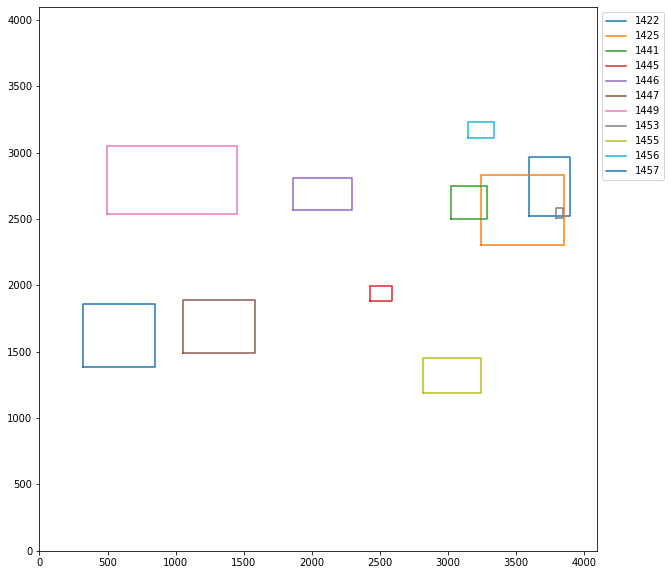

In [131]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

ax.set_ylim(0,4096)
ax.set_xlim(0,4096)

for harp_num, group in joined_time_stamp.groupby(['HARPNUM']):


    for _, row in group.iterrows():

        # print(row['T_REC'])

        array_bbox = np.array(row.pixel_bbox)

        ax.plot(array_bbox[:,0], array_bbox[:,1], label = harp_num)

# ax.legend(l/oc='upper left', bbox_to_anchor=(1, 1))

# ax.scatter(x1,y1)
# ax.scatter(x2,y2)

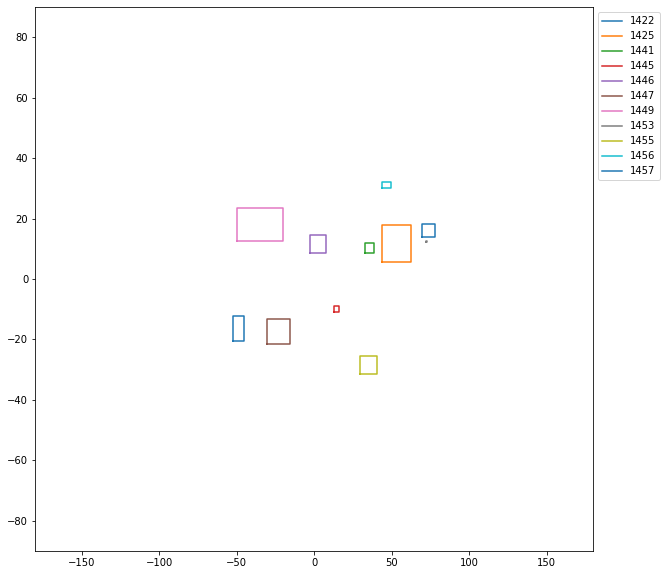

In [136]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)


ax.set_ylim(-90,90)
ax.set_xlim(-180,180)


for harp_num, group in joined_time_stamp.groupby(['HARPNUM']):

    for _, row in group[:1].iterrows():

        array_bbox = np.array(row.hgs_bbox)

        ax.plot(array_bbox[:,0], array_bbox[:,1], label = harp_num)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [57]:
# joined_time_stamp['pixel_bbox_2'] = [get_pixel_boundary_box(row) for _,row in joined_copy.iterrows()]

# joined_time_stamp.hgs_bbox.iloc[0], joined_time_stamp.CROTA2.iloc[0], joined_time_stamp.RSUN_OBS.iloc[0]

# joined_time_stamp[['hgs_bbox', 'CROTA2', 'RSUN_OBS', 'CDELT1']].iloc[0]

hgs_bbox    [[38.109142, 2.55276], [38.109142, 11.704672],...
CROTA2                                             180.013611
RSUN_OBS                                           945.541992
CDELT1                                               0.504361
Name: 0, dtype: object

In [64]:
# crota2, rsun, cdelt1, crsize1, crsize2 = joined_time_stamp[ ['CROTA2', 'RSUN_OBS', 'CDELT1', 'CRSIZE1', 'CRSIZE2']].iloc[0]

# # lower left-hand corner
# x1_1 = (keys_ccd.IMCRPIX1[0] - keys_ccd.CRPIX1[0])
# y1_1 = (keys_ccd.IMCRPIX2[0] - keys_ccd.CRPIX2[0]) 


# np.abs(crsize1*np.cos(crota2)- crsize2*np.sin(crota2))*cdelt1

29.262597117093758

In [65]:
# abs(crsize2* np.cos(crota2)+ crsize1* np.sin(crota2))*cdelt1

364.0406208054454

In [66]:
# joined_time_stamp[ ['CRPIX1','CRPIX2']].iloc[0]

CRPIX1     401.0
CRPIX2    1724.0
Name: 0, dtype: float64